In [9]:
import sys
import os
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywt import threshold, wavedec, Wavelet, waverec
import math

sys.path.append(os.getcwd()+'/../scripts/')
from Preprocessing import Preprocessing

plt.rcParams["figure.figsize"]=20,10
plt.rcParams.update({'font.size': 28})
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2

In [8]:
data = pd.read_csv('../data/final/nan_data.csv', index_col=0)
pre = Preprocessing()

In [30]:
data = pd.read_csv('../data/final/nan_firmness_data.csv', index_col=0)
pre = Preprocessing()

In [2]:
data = pd.read_csv('../data/final/nan_sst_data.csv', index_col=0)
pre = Preprocessing()

In [10]:
data = pd.read_csv('../data/final/nan_drymass_data.csv', index_col=0)
pre = Preprocessing()

In [11]:
abs_data = data[data.columns[4:]]
qua_data = data[data.columns[:4]]

In [33]:
abs_data = data[data.columns[14:]]
qua_data = data[data.columns[:14]]

In [12]:
n_samples = data.shape[0]

In [13]:
def plot(data):
    fig, ax = plt.subplots()
    if data.ndim == 1:
        a = plt.plot(data)
    else:
        a = plt.plot(data.columns, data.T)
    
    plt.xticks([])
    plt.title('Absorbance x Wavelength')
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')

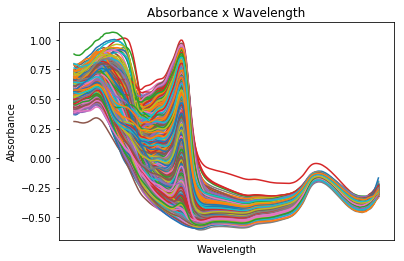

In [12]:
plot(abs_data)

# mean centering

In [177]:
mean_centered_arr = pre.mean_center(abs_data.values)
mean_centered_df = pd.DataFrame(data=mean_centered_arr, index=np.arange(n_samples), columns=abs_data.columns)

# moving average

In [14]:
mov_windows = [5, 7, 9, 11]
d_order = [1, 2]
d_windows = [5, 7, 9, 11]
norms = [pre.msc, pre.snv]
pre_treated = data.copy()

for mov_window in mov_windows:
    smoothed = pre.moving_average(abs_data.values, mov_window)
    for order in d_order:
        for d_window in d_windows:
            derivated = pre.sav_gol_derivative(smoothed, order, 2, d_window)
            for norm in norms:
                normalized = norm(derivated)
                pre_treated[abs_data.columns] = normalized
                pre_treated.to_csv('../data/preprocessed/movavg%s_deriv%sw%s_norm%s.csv' % \
                                   (mov_window, order, d_window, norm.__name__))

# savitzky golay

In [15]:
sav_windows = [5, 7, 9, 11]
d_order = [1, 2]
d_windows = [5, 7, 9, 11]
norms = [pre.msc, pre.snv]

for sav_window in sav_windows:
    smoothed = pre.sav_gol(abs_data.values, 2, sav_window)
    for order in d_order:
        for d_window in d_windows:
            derivated = pre.sav_gol_derivative(smoothed, order, 2, d_window)
            for norm in norms:
                normalized = norm(derivated)
                pre_treated[abs_data.columns] = normalized
                pre_treated.to_csv('../data/preprocessed/savavg%s_deriv%sw%s_norm%s.csv' % \
                                   (sav_window, order, d_window, norm.__name__))

# wavelet

In [12]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [16]:
wnames = ['db3', 'db4']
levels = [2, 3, 4]
d_order = [1, 2]
d_windows = [5, 7, 9, 11]
norms = [pre.msc, pre.snv]

for wname in wnames:
    for level in levels:
        smoothed = pre.wavelet_denoising(abs_data.values, wname, level)
        for order in d_order:
            for d_window in d_windows:
                derivated = pre.sav_gol_derivative(smoothed, order, 2, d_window)
                for norm in norms:
                    normalized = norm(derivated)
                    pre_treated[abs_data.columns] = normalized
                    pre_treated.to_csv('../data/preprocessed/wav%sl%s_deriv%sw%s_norm%s.csv' % \
                                       (wname, level, order, d_window, norm.__name__))